# Validation - ResNet Autoencoder (AE) for ECAL DQM 
EB Occupancy

In [1]:
import numpy as np
np.random.seed(0)
import pyarrow as pa
import pyarrow.parquet as pq
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import *

import time
import os, glob
# Specify which gpuid to use
os.environ["CUDA_VISIBLE_DEVICES"]=str(0)

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator, FixedLocator
%matplotlib inline

In [2]:
from torch.utils.data import sampler

In [3]:
import sys
np.set_printoptions(threshold=sys.maxsize)


Do a test read of the input data:

In [5]:
from matplotlib import colors, cm
hsv = cm.get_cmap('hsv', 12)
binary_cmap = colors.ListedColormap([hsv(0.38), 'red'])

<ipython-input-5-bf2ddd3df84e>:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  hsv = cm.get_cmap('hsv', 12)


In [6]:
plt.rcParams["figure.figsize"] = (8,6)

def plot_EB(img, vmin=0., vmax=3., cmap='jet', label='Normalized Occupancy', extend_edge=False,typestr='_', t_str='_', epoch=1,norm=None,save=False, cbar=True): # cmap = 'jet'
                  
    # Only plots single channel, single sample images
    img = img.squeeze()
    assert len(img.shape) == 2
    
    if extend_edge:
        ieta_max = 18
    else:
        img = img[1:-1,:] if img.shape[-2] > 34 else img
        ieta_max = 17
    
    fig, ax = plt.subplots()
    im = ax.imshow(img, vmin=vmin, vmax=vmax, cmap=cmap, origin='lower')
    if cbar==True:
        ax.figure.colorbar(im, ax=ax, fraction=0.0228, pad=0.015, label=label)

    # By default, imshow() places tick marks at center of image pixel, 
    # so need to shift to the low side by 0.5 to match DQM convention
    # of ticks being placed on low edge of bin
    off = 0.5
    # Set image coordinates where ticks should appear...
    ax.set_xticks(np.arange(0,72+8,8)-off)
    ax.set_yticks(np.arange(0,(2*ieta_max)+ieta_max,ieta_max)-off)
    # then set what values should be displayed at these coordinates
    ax.set_xticklabels(np.arange(0,72+8,8))
    ax.set_yticklabels([-ieta_max,0,ieta_max])
    # Make ticks face inward
    ax.xaxis.set_tick_params(direction='in', which='major', length=6.,labelsize=10)
    ax.xaxis.set_tick_params(direction='in', which='minor', length=3.,labelsize=10)
    ax.yaxis.set_tick_params(direction='in', which='major', length=6.,labelsize=10)
    ax.yaxis.set_tick_params(direction='in', which='minor', length=3.,labelsize=10)

    # Plot supermodule boundaries. Need to apply same offset for plot()
    # Horizontal +/- eta boundary
    ax.plot([0-off,72-off],[ieta_max-off,ieta_max-off], linewidth=1., linestyle='--', color='black')
    # Vertical phi boundaries
    for iphi in np.arange(0,72,4):
        ax.plot([iphi-off,iphi-off],[0-off,(2*ieta_max)-off], linewidth=1., linestyle='--', color='black')
    plt.xlabel(r'$\mathrm{i\varphi_{tow}}$', size=16)
    plt.ylabel(r'$\mathrm{i\eta_{tow}}$', size=16)
    if save==True:
        plt.savefig('%s.png' %t_str, bbox_inches='tight')

    plt.show()
    plt.close()

In [8]:
def rebin(a, shape):
    sh = shape[0],a.shape[0]//shape[0],shape[1],a.shape[1]//shape[1]
    print(a.shape,sh)
    return a.reshape(sh).sum(-1).sum(1)

In [7]:
d2 = np.array(f.read_row_group(0).to_pydict()['EBIntegrityClient_EBIT_channel_status_map'])
d2=d2.reshape(170,360)
print(d2.shape)
#plot_EB(d2, vmax=d2.max(), cmap='jet',label='Channel Status Map')
d2_=d2.copy()
d2_[d2_> 0]=1
d2_[d2_<=0]=0
#plot_EB(d2_,vmin=0.,vmax=1., cmap='jet',label='Channel Status Map')

(170, 360)


(170, 360) (34, 5, 72, 5)
(34, 72)
25.0
1.0


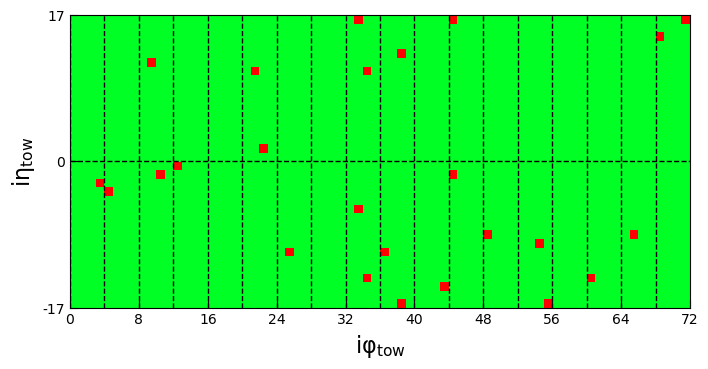

In [9]:
#Get channel status map to identify masked towers
f = pq.ParquetFile('Good_parquet/run325170_channel_status.parquet')
print(f.schema)
print(f.metadata)

d2 = np.array(f.read_row_group(0).to_pydict()['EBIntegrityClient_EBIT_channel_status_map'])
d2=d2.reshape(170,360)
print(d2.shape)
d2_=d2.copy()
d2_[d2_> 0]=1
d2_[d2_<=0]=0

#Rebin to tower level (5x5 crystals)
shape=[34, 72]
reb_d2=rebin(d2_,shape)

ch_status = reb_d2.copy()

print(ch_status.shape)
print(ch_status.max())
ch_status[ch_status <= 5. ] =0.
ch_status[ch_status > 5. ] = 1.
print(ch_status.max())


plot_EB(ch_status,vmin=0,vmax=1, cmap=binary_cmap, cbar=False, label='Channel Status Map')

## Define pre-processing routines and any necessary plotting functions

In [ ]:
fit = np.loadtxt('PU_corr_EB_2018.txt')


In [10]:
def apply_PU_corr(img,pu):
    '''
    Function to correct occupancy for PU
    '''
    img = img/(fit[0]*pu + fit[1])
    img *= 34*72
    #img = img/0.9
    return img

In [11]:
def apply_PU_corr2(img,pu):
    '''
    Function to correct occupancy for PU for 36x72 
    '''
    img = img/(fit[0]*pu + fit[1])
    img *= 36*72

    return img

Do check on test data:

# Define input datasets

Define how "good" samples are to be read in

In [12]:
class ParquetDataset(Dataset):
    '''
    Define Dataset class for "good" samples.
    Occ vs PU correction to be applied here to obtain a normalized occupancy as a fn of PU
    '''
    def __init__(self, filename):
        self.parquet = pq.ParquetFile(filename)
        #self.cols = None # read all columns
        self.cols = ['EBOccupancyTask_EBOT_digi_occupancy.list.item.list.item','PU']
    def __getitem__(self, index):
        data = self.parquet.read_row_group(index, columns=self.cols).to_pydict()
        data['EBOccupancyTask_EBOT_digi_occupancy'] = np.float32(data['EBOccupancyTask_EBOT_digi_occupancy'][0]).reshape(-1,34,72)
        data['PU']= np.float32(data['PU'][0])
        #data['run']= np.float32(data['run'][0])
        data['EBOccupancyTask_EBOT_digi_occupancy'] = apply_PU_corr(data['EBOccupancyTask_EBOT_digi_occupancy'], data['PU'])
        data['index'] = index   
        #Edges are padded to mitigate the "edge effect" of suboptimal learning at the boundaries
        data['EBOccupancyTask_EBOT_digi_occupancy'] = np.pad(data['EBOccupancyTask_EBOT_digi_occupancy'], ((0,0), (1,1), (0,0)), 'edge')
       
        return (data)

    def __len__(self):
        return self.parquet.num_row_groups

Define how "anomaly" samples are to be read in

In [13]:
class ParquetDatasetHot(Dataset):
    '''
    Define Dataset class for anomalous hot-tower samples.
    Occ vs PU correction is not applied here, as it is applied after the hot tower is defined
    '''
    def __init__(self, filename):
        self.parquet = pq.ParquetFile(filename)
        self.cols = None # read all columns
        self.cols = ['EBOccupancyTask_EBOT_digi_occupancy.list.item.list.item','PU']
    def __getitem__(self, index):
        data = self.parquet.read_row_group(index, columns=self.cols).to_pydict()
        data['EBOccupancyTask_EBOT_digi_occupancy'] = np.float32(data['EBOccupancyTask_EBOT_digi_occupancy'][0]).reshape(-1,34,72)
        data['PU']= np.float32(data['PU'][0])
        #data['EBOccupancyTask_EBOT_digi_occupancy'] = apply_PU_corr(data['EBOccupancyTask_EBOT_digi_occupancy'], data['PU'])
        data['index'] = index
        #Edges are padded to mitigate the "edge effect" of suboptimal learning at the boundaries
        data['EBOccupancyTask_EBOT_digi_occupancy'] = np.pad(data['EBOccupancyTask_EBOT_digi_occupancy'], ((0,0), (1,1), (0,0)), 'edge')
        return dict(data)
    def __len__(self):
        return self.parquet.num_row_groups

Split data into training, validation, and anomaly sets

--

--

In [14]:
dset_val = ParquetDataset('Good_parquet/500ev.val.parquet')


In [15]:
dset_hot = ParquetDatasetHot('Good_parquet/500ev.val.parquet')

In [16]:
sampler_val = sampler.SequentialSampler(dset_val)
loader_val = DataLoader(dataset=dset_val, batch_size=3, num_workers=4, sampler=sampler_val)
loader_hot=DataLoader(dataset=dset_hot, batch_size=3, num_workers=4, sampler=sampler_val)

In [19]:
avg_occ=np.loadtxt('avgocc.txt')
avg_loss=np.loadtxt('avgloss.txt')
avg_reco=np.loadtxt('avgreco.txt')

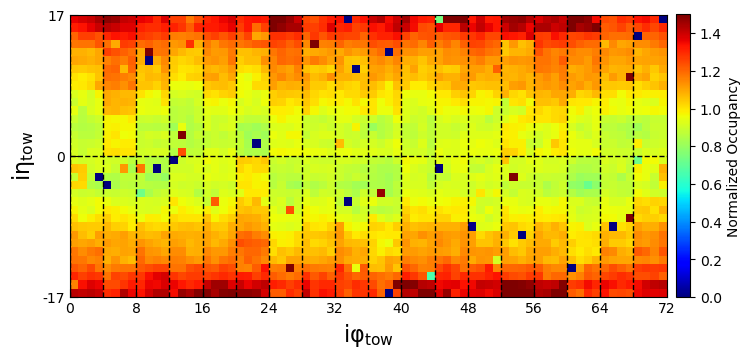

In [20]:
plot_EB(avg_occ,t_str='Occupancy', vmax=1.5, cmap='jet')

In [21]:
#Convert to tensor for spatial response correction
avg_occ_T=toch.from_numpy(avg_occ).float().cuda()

# Define AE model



Define ResNet blocks for encoding and decoding

In [22]:
class ResBlock(nn.Module):
    '''
    For encoding, define the nominal resnet block
    '''
    def __init__(self, in_channels, out_channels):
        super(ResBlock, self).__init__()
        self.downsample = out_channels//in_channels
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=self.downsample, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=self.downsample)

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)

        if self.downsample > 1:
            residual = self.shortcut(x)

        out += residual
        out = self.relu(out)

        return out

class ResBlockTranspose(nn.Module):
    '''
    For decoding, define the transposed resnet block, aka "de-convolution"
    '''
    def __init__(self, in_channels, out_channels, out_shape=None):
        super(ResBlockTranspose, self).__init__()
        self.upsample = in_channels//out_channels  
        self.convT1 = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=self.upsample, padding=1)
        #self.convT1 = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=self.upsample, padding=0)
        self.relu = nn.ReLU(inplace=True)
        self.convT2 = nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, padding=1)
        #self.convT2 = nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, padding=0)

        self.shortcutT = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=1, stride=self.upsample)
        #self.shortcutT = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=1, stride=self.upsample, padding=0)
        self.out_shape = out_shape

    def forward(self, x):
        residual = x
        
        if self.out_shape is None:
            out = self.convT1(x)
        else:
            out = self.convT1(x, output_size=(x.size()[0], x.size()[1], self.out_shape[0], self.out_shape[1]))
        out = self.relu(out)
        out = self.convT2(out)

        if self.upsample > 1:
            if self.out_shape is None:
                residual = self.shortcutT(x)
            else:
                residual = self.shortcutT(x, output_size=(x.size()[0], x.size()[1], self.out_shape[0], self.out_shape[1]))
            
        out += residual
        out = self.relu(out)

        return out

Define the full ResNet autoencoder module. NOTE: Getting the right dimensions on the decoding (upsampling) is tricky and adding unnecessary padding can potentially lead to dead spots in the AE-reco image... to be tuned.

In [23]:
class ResNetAE(nn.Module):
    '''
    Define the full ResNet autoencoder model
    '''
    def __init__(self, in_channels, nblocks, fmaps):
        super(ResNetAE, self).__init__()

        self.fmaps = fmaps
        self.nblocks = nblocks
        self.in_channels = in_channels
        
        #3x3, s=1, down4/5
        # Initialize encoding layers
        self.econv0 = nn.Sequential(nn.Conv2d(in_channels, fmaps[0], kernel_size=3, stride=1, padding=1), nn.ReLU())
        self.elayer1 = self.block_layers(self.nblocks, [fmaps[0],fmaps[0]], 'enc')
        self.elayer2 = self.block_layers(1, [fmaps[0],fmaps[1]], 'enc')
        self.elayer3 = self.block_layers(self.nblocks, [fmaps[1],fmaps[1]], 'enc')
        self.elayer4 = self.block_layers(1, [fmaps[1],fmaps[2]], 'enc')
        self.elayer5 = self.block_layers(self.nblocks, [fmaps[2],fmaps[2]], 'enc')
        
        # Initialize decoding layers
        self.fc = nn.Linear(self.fmaps[-1], self.fmaps[-1]*5*9) # 5x5
        self.dlayer5 = self.block_layers(self.nblocks, [fmaps[2],fmaps[2]], 'dec', out_shape=None)
        self.dlayer4 = self.block_layers(1, [fmaps[2],fmaps[1]], 'dec', out_shape=(9,18))
        self.dlayer3 = self.block_layers(self.nblocks, [fmaps[1],fmaps[1]], 'dec', out_shape=None)
        self.dlayer2 = self.block_layers(1, [fmaps[1],fmaps[0]], 'dec', out_shape=(18,36))
        self.dlayer1 = self.block_layers(self.nblocks, [fmaps[0],fmaps[0]], 'dec', out_shape=None)
        #self.dconv0 = nn.ConvTranspose2d(fmaps[0], in_channels, kernel_size=7, stride=2, padding=(0,1))
        self.dconv0 = nn.ConvTranspose2d(fmaps[0], in_channels, kernel_size=3, stride=1, padding=(1,1))
        self.dconv0_relu = nn.ReLU(inplace=True)
        
        self.debug = False
        #self.debug = True

    def block_layers(self, nblocks, fmaps, state, out_shape=None):
        '''
        Convenience function: append several resnet blocks in sequence
        '''
        layers = []
        for _ in range(nblocks):
            if state == 'enc':
                layers.append(ResBlock(fmaps[0], fmaps[1]))
            else:
                layers.append(ResBlockTranspose(fmaps[0], fmaps[1], out_shape)) 
        return nn.Sequential(*layers)

    '''
    For VAE:
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size()).cuda()
        z = mu + std * esp
        return z
    '''

    def forward(self, x):
        
        # Encoding
        if self.debug: print(x.size())
        if self.debug: print("Encode")
        x = self.econv0(x)
        if self.debug: print(x.size())
        x = F.max_pool2d(x, kernel_size=2)
        if self.debug: print(x.size())

        x = self.elayer1(x)
        if self.debug: print(x.size())
        x = self.elayer2(x)
        if self.debug: print(x.size())
        x = self.elayer3(x)
        if self.debug: print(x.size()) #32x9x18
        x = self.elayer4(x)
        if self.debug: print(x.size())
        x = self.elayer5(x)
        if self.debug: print(x.size())
        
        # Bottleneck comes from GlobalMaxPool
        if self.debug: print("Maxpool-FC")
        x = F.max_pool2d(x, kernel_size=x.size()[2:]) #32x9x18 -> 32x1 : Global max of each map.
        #if self.debug: print(x.size())
        x = x.view(x.size()[0], -1)
        if self.debug: print(x.size())
        
        '''
        For VAE:
        mu, logvar = self.fc_mu(x), self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)
        '''
        
        # Expand bottleneck
        # Dimensions follow encoding steps in reverse, as much as possible
        x = self.fc(x) # expand   #32x1->FCN
        if self.debug: print(x.size())
        #x = x.view(-1, self.fmaps[1], 4, 9) # 7x7, s=2
        #x = x.view(-1, self.fmaps[1], 9, 18) # 5x5 or 3x3, s=1  #restructure back to 32x9x18
        x = x.view(-1, self.fmaps[-1], 5, 9) # 3x3, down4/5
        if self.debug: print(x.size())        
        
        # Decoding
        if self.debug: print("Decode")
        x = self.dlayer5(x)
        if self.debug: print(x.size())
        x = self.dlayer4(x)
        if self.debug: print(x.size())
        x = self.dlayer3(x)
        if self.debug: print(x.size())
        x = self.dlayer2(x)
        if self.debug: print(x.size())
        x = self.dlayer1(x)
        if self.debug: print(x.size())
        
        x = F.interpolate(x, scale_factor=2)
        if self.debug: print(x.size())
        x = self.dconv0(x, output_size=(x.size()[0], self.in_channels, 2+170//5, 360//5))
        if self.debug: print(x.size())
        x = self.dconv0_relu(x)
            
        return x
        #return x, mu, logvar

---

---

In [24]:
#LOAD A MODEL
filepath='MODELS/Pad_ResNet_3_16_32_64_epoch50/model_anom_resnetAE_EBOcc_epoch32_loss=4.2E-02.pkl'#model_anom_resnetAE_EBOcc_epoch29_FDR=3.6E-02.pkl'#model_Test_anom_resnetAE_EBOcc_epoch50_loss=0.058725.pkl  # #ResNet_3_16_32_train70/model_Val_SM_anom_resnetAE_EBOcc_epoch50_loss=0.039160.pkl'#
loaded_model = ResNetAE(1, 3, [16, 32, 64])
checkpoint = torch.load(filepath)
#checkpoint.eval()
loaded_model.load_state_dict(checkpoint['model']) #'model'= 'state_dict' here
loaded_model.cuda()
loaded_model.eval()



ResNetAE(
  (econv0): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (elayer1): Sequential(
    (0): ResBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (shortcut): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): ResBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (shortcut): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
    )
    (2): ResBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (shortcut): Conv2d(16, 16, kernel_size=(1, 1), stri

In [25]:
def getMeanEta(img_):
    img_[ch_status == 1.]=-1
    projEta=[]
    for i in range(34):
        c=0
        summ=0.0
        for j in range(72):
        #print('Entering iphi (j) loop %d' %j)
            if img_[i][j]>=0:
                c+=1.
                summ+=img_[i][j]
        projEta.append(summ/c)
    
    n=len(projEta)
    #print(n)
    eta_avg_=[]

    for i in range(17):
           eta_avg_.append((projEta[i]+projEta[n-i-1])/2)

    eta_avg=np.zeros(n)

    for i in range(17):
        eta_avg[i]=eta_avg_[i]
        eta_avg[n-i-1]=eta_avg_[i]
    
    eta_avg=eta_avg.reshape(-1,1)
    #print(eta_avg.shape)
    return(eta_avg)

In [26]:
def get_roc(loss_maps, loss_map_anoms,rate=1,doPrint=False):
    
    anom_map=loss_map_anoms[loss_map_anoms>=0]
    norm_map=loss_maps[loss_maps >=0]
   
    anom_thres=np.percentile(anom_map,rate)
    
    FP = len(norm_map[norm_map > anom_thres])
    TP = len(anom_map[anom_map > anom_thres])
    
    FN = len(anom_map[anom_map < anom_thres])
    TN = len(norm_map[norm_map < anom_thres])
    
    FNR = FN/(FN+TP)
    FPR = FP/(FP+TN)
    
    TPR = TP/(TP+FN)
    TNR = TN/(TN+FP)
    
    FDR = FP/(FP+TP)
    
    if doPrint:
        print("\n")
        print(f'TPR: {TP}/{TP+FN}={1-rate*0.01}')
        print('Anomaly threshold = {:.5f}'.format(anom_thres))
        print('FPR: {}/{}={:.5f}'.format(FP,FP+TN,FPR))
        print('FDR = {}/{}={:.5f}'.format(FP,FP+TP,FDR))
    
    return FDR, anom_thres, TP, FP, TN, FN


def get_roc_auc(loss_maps, loss_map_anoms):
    TPR = []
    FPR = []
    FDRs= []
    
    epsilon = 0.00001
    scan_range = np.linspace(0+epsilon,1-epsilon,10000)
    for point in scan_range:
        #print(point)
        FDR, anom_thres, TP, FP, TN, FN = get_roc(loss_maps, loss_map_anoms, 100*point)
        TPR.append(TP/(TP+FN))
        FPR.append(FP/(FP+TN))
        FDRs.append(FDR)
        
    FDR, anom_thres, TP, FP, TN, FN = get_roc(loss_maps, loss_map_anoms, 1, doPrint=True)  # 99%
    FDR, anom_thres, TP, FP, TN, FN = get_roc(loss_maps, loss_map_anoms, 5, doPrint=True)  # 95%
    FDR, anom_thres, TP, FP, TN, FN = get_roc(loss_maps, loss_map_anoms, 10, doPrint=True) # 90%
        
    return TPR, FPR, FDRs


# EVALUATIONS

# DEAD/HOT towers

In [30]:
#Random single tower maps
arr_val = np.argwhere(ch_status==1)

np.random.seed(1)
rand_arr=[]
for i in range(34000):
    k1=np.random.randint(1,34)  #with no padding (0,33)
    k2=np.random.randint(0,71)
    a=[k1, k2]
    rand_arr.append(a)
#arr.append([ 0, 3, 60])
print(len(rand_arr))

#Dont consider already masked towers to apply the anomaly
r_arr=[x for x in rand_arr if x not in arr_val]
print(len(r_arr))
dict_tow={i:v for i,v in enumerate(r_arr)}

34000


In [32]:
def apply_anom_tow(img,index):
    k1,k2=dict_tow[index][0], dict_tow[index][1]
    img[:,k1,k2]=0
    return img

In [33]:
def apply_anom_HotTow(img,index,par):
    k1,k2=dict_tow[index][0], dict_tow[index][1]
    img[:,k1,k2]=25.*500.*par
    return img

### DEAD TOWERS ###

In [34]:
def do_eval_tow(ae, loader, epoch, dstr='EBOccupancyTask_EBOT_digi_occupancy', idx=0, typestr='_'):
    loss_ = []
    loss_map_anom=[]
    loss_map=[]
    
    eta_diff_norm=[]
    eta_diff_anom=[]
    
    
    R_lmap=[]
    R_lmap_anom=[] 
    eta_tmap=[]
    eta_anom_tmap=[]
    
    
    now = time.time()
    c=0
    #loss_mult=np.ones((34,72))
    print('val loader len = %d'%len(loader))
    for i, data in enumerate (loader):
        if i >-1:#< len(loader)-1:
            X=data['EBOccupancyTask_EBOT_digi_occupancy'].cuda()
            pu= data['PU'].cuda()
           
            loss_map=[]
            loss_map_anom=[]
            eta_diff_norm=[]
            eta_diff_anom=[]
            
            for idx in range(len(X)):
                index=(idx+3*i)           
                img=X[idx].cpu().numpy()
                #img=img/0.005
                pu_i=pu[idx].cpu().numpy()
                k1,k2=dict_tow[i][0], dict_tow[i][1]
                
                img[:,k1,k2]= 0.  #dead
            
                
                img_T=torch.from_numpy(img).float().cuda()  
                #print('\nSize of image before resize')
                #print(img_T.size())
                img_T.resize_(1,1,36,72)
                #print('Size of image after resize')
                #print(img_T.size())
                
                img_reco_T=loaded_model(img_T)
                #print('\nSize of reco before cut')
                #print(img_reco_T.size())
                
                #Padding removed during evaluation
                img_reco_T=img_reco_T[...,1:-1,:]
                img_T=img_T[...,1:-1,:]
                #print('Size of reco after cut')
                #print(img_reco_T.size())
                
                #Spatial response correction  by dividing by the average occupancy
                img_loss=F.mse_loss(img_reco_T/avg_occ_T, img_T/avg_occ_T, reduction='none').detach().cpu().numpy()
                                       
                img_reco=img_reco_T.detach().cpu().numpy()
                                                    
                img_loss2 = img_loss[0][0].copy()

                img_loss2[ch_status == 1.]= -1. 
                img=img[...,1:-1,:]
  
                img_loss3= img_loss2.copy()
    
                k1=k1-1
    
                img_loss3[k1,k2] =-1.
        
                
                loss_map.append(img_loss3.flatten())
                loss_map_anom.append(img_loss2[k1,k2].flatten())
                
                img_=img.squeeze()
                eta_avg=getMeanEta(img_)
                
                diff=abs(img_ - eta_avg) #baseline difference map 34x72
                diff[ch_status ==1.]= -1.
                
            
                diff_norm=diff.copy()
                diff_norm[k1,k2]=-1.
            
                eta_diff_norm.append(diff_norm.flatten())
                eta_diff_anom.append(diff[k1,k2].flatten())
           
            if len(loss_map)< 3:
                continue
            
            #Time correction - 3 LS multiplication
            R_lmap.append(loss_map[0]*loss_map[1]*loss_map[2])
            R_lmap_anom.append(loss_map_anom[0]*loss_map_anom[1]*loss_map_anom[2])#*l
            
            
    l_map = np.concatenate(R_lmap) #(loss_map)#
    l_map_anom = np.concatenate(R_lmap_anom) #(loss_map_anom)#
   
   

    
    TPR, FPR, FDRs = get_roc_auc(l_map, l_map_anom) 

    return TPR, FPR, FDRs

In [35]:
#With auc
TPR, FPR, FDRs = do_eval_tow(loaded_model, loader_val, epoch=50, typestr='Val_anom')

val loader len = 3275


TPR: 3207/3240=0.99
Anomaly threshold = 0.32874
FPR: 138/7929662=0.00002
FDR = 138/3345=0.04126


TPR: 3078/3240=0.95
Anomaly threshold = 0.42903
FPR: 111/7929662=0.00001
FDR = 111/3189=0.03481


TPR: 2916/3240=0.9
Anomaly threshold = 0.48600
FPR: 97/7929662=0.00001
FDR = 97/3013=0.03219


In [ ]:
np.savetxt('EB_Deadtow_FDRs.txt', FDRs)
np.savetxt('EB_Deadtow_TPR.txt', TPR)
np.savetxt('EB_Deadtow_FPR.txt', FPR)

### HOT TOWERS ###

In [ ]:
def do_eval_hottow(ae, loader, epoch, dstr='EBOccupancyTask_EBOT_digi_occupancy', idx=0, typestr='_'):
    loss_ = []
    loss_map_anom=[]
    loss_map=[]
    
    eta_diff_norm=[]
    eta_diff_anom=[]
    
    
    R_lmap=[]
    R_lmap_anom=[] 
    eta_tmap=[]
    eta_anom_tmap=[]
    
    
    now = time.time()
    c=0
    
    print('val loader len = %d'%len(loader))
    for i, data in enumerate (loader):
        if i >-1:#< len(loader)-1:
            X=data['EBOccupancyTask_EBOT_digi_occupancy'].cuda()
            pu= data['PU'].cuda()
           
            loss_map=[]
            loss_map_anom=[]
            eta_diff_norm=[]
            eta_diff_anom=[]
            
            for idx in range(len(X)):
                index=(idx+3*i)           
                img=X[idx].cpu().numpy()
                pu_i=pu[idx].cpu().numpy()
                k1,k2=dict_tow[i][0], dict_tow[i][1]
    
            
                img[:,k1,k2]=25.*500.*0.1  # 10% hot
                img = apply_PU_corr2(img,pu_i) #apply PU correction after the hot tower is added.
                
                img_T=torch.from_numpy(img).float().cuda()  
                #print('\nSize of image before resize')
                #print(img_T.size())
                img_T.resize_(1,1,36,72)
                #print('Size of image after resize')
                #print(img_T.size())
                
                img_reco_T=loaded_model(img_T)
                #print('\nSize of reco before cut')
                #print(img_reco_T.size())
                
                #Padding removed during evaluation
                img_reco_T=img_reco_T[...,1:-1,:]
                img_T=img_T[...,1:-1,:]
                #print('Size of reco after cut')
                #print(img_reco_T.size())
                
                #Spatial response correction  by dividing by the average occupancy
                img_loss=F.mse_loss(img_reco_T/avg_occ_T, img_T/avg_occ_T, reduction='none').detach().cpu().numpy()
                                       
                img_reco=img_reco_T.detach().cpu().numpy()
              
        
                                                                     
                img_loss2 = img_loss[0][0].copy()
                #print(img_loss2.shape)
                #break
                img_loss2[ch_status == 1.]= -1. 
                img=img[...,1:-1,:]

                img_loss3= img_loss2.copy()
    
                k1=k1-1
                
         
                img_loss3[k1,k2] =-1.
        
                
                loss_map.append(img_loss3.flatten())
                loss_map_anom.append(img_loss2[k1,k2].flatten())

                img_=img.squeeze()
                eta_avg=getMeanEta(img_)
                
                diff=abs(img_ - eta_avg) #baseline difference map 34x72
                diff[ch_status ==1.]= -1.
                
            
                diff_norm=diff.copy()
                diff_norm[k1,k2]=-1.
            
                eta_diff_norm.append(diff_norm.flatten())
                eta_diff_anom.append(diff[k1,k2].flatten())
           
            if len(loss_map)< 3:
                continue
                
            #Time correction - 3 LS multiplication
            R_lmap.append(loss_map[0]*loss_map[1]*loss_map[2])
            R_lmap_anom.append(loss_map_anom[0]*loss_map_anom[1]*loss_map_anom[2])
            
            eta_tmap.append(eta_diff_norm[0]*eta_diff_norm[1]*eta_diff_norm[2])
            eta_anom_tmap.append(eta_diff_anom[0]*eta_diff_anom[1]*eta_diff_anom[2])
   
   
    l_map = np.concatenate(R_lmap) #(loss_map)#
    l_map_anom = np.concatenate(R_lmap_anom) #(loss_map_anom)#
   
    eta_diff_norm=np.concatenate(eta_tmap) #(eta_diff_norm) #
    eta_diff_anom=np.concatenate(eta_anom_tmap) #(eta_diff_anom) #
    #print(len(eta_diff_norm), len(eta_diff_anom))
    
   
    TPR, FPR, FDRs = get_roc_auc(l_map, l_map_anom) 

    return TPR, FPR, FDRs


In [ ]:
_ =do_eval_hottow(loaded_model, loader_hot, epoch=50, typestr='Val_anom') 

----

# MISSING SM

In [ ]:
#Random SM generator
np.random.seed(0)
p=np.random.randint(0,35, size=35000)
dict_sm={i:v for i,v in enumerate(p)}


def find_anom_SM(index):
    k=dict_sm[index]
    #k=p_arr[index]
    if k <18:
            a1=0
            a2=17
            b1=4*k
            b2=4*(k+1)    #img[:,:17,4*k:4*(k+1)] = 0
    else:
            c=k-18
            a1=17
            a2=34
            b1=4*c
            b2=4*(c+1)
                            #img[:,17:34,4*c:4*(c+1)]=0
    return a1,a2,b1,b2




In [ ]:
def apply_anom_SM(img,index):
    '''
    randomly drop supermodules
    '''
   
    k=dict_sm[index]
    if k <18:
        img[:,0:18,4*k:4*(k+1)] = 0
    else:
        c=k-18
        img[:,18:36,4*c:4*(c+1)]=0
    return img



In [ ]:
def do_eval_SM(ae, loader, epoch, dstr='EBOccupancyTask_EBOT_digi_occupancy', idx=0, typestr='_'):
    loss_ = []
    loss_map_anom=[]
    loss_map=[]

    R_lmap=[]
    R_lmap_anom=[]
    
    #ind=[]
    eta_tmap=[]
    eta_anom_tmap=[]
    
     
    eta_diff_norm=[]
    eta_diff_anom=[]
   
    now = time.time()
   
    #loss_mult=np.ones((34,72))
    print('val loader len = %d'%len(loader))
    for i, data in enumerate (loader):
        #if i >-1: #len(loader)-1:
            X=data['EBOccupancyTask_EBOT_digi_occupancy'].cuda()
            
      
            loss_map=[]
            loss_map_anom=[]
            
            eta_diff_norm=[]
            eta_diff_anom=[]
            for idx in range(len(X)):
                #print(len(X))
                
                index=(idx+3*i)           
                img=X[idx].cpu().numpy()    
                #print(i)
                
                img = apply_anom_SM(img,i)
                #print('applied')
                
                #print('Image %d index %d' %(i,index))
                #plot_EB(img)
                img_T=torch.from_numpy(img).float().cuda()  
                #print('\nSize of image before resize')
                #print(img_T.size())
                img_T.resize_(1,1,36,72)
                #print('Size of image after resize')
                #print(img_T.size())
                img_reco_T=loaded_model(img_T)
                #print('\nSize of reco before cut')
                #print(img_reco_T.size())
                
                #Padding removed during evaluation
                img_reco_T=img_reco_T[...,1:-1,:]
                img_T=img_T[...,1:-1,:]
                #print('Size of reco after cut')
                #print(img_reco_T.size())
                
                #Spatial response correction  by dividing by the average occupancy
                img_loss=F.mse_loss(img_reco_T/avg_occ_T, img_T/avg_occ_T, reduction='none').detach().cpu().numpy()
                img_reco=img_reco_T.detach().cpu().numpy()
               
                                                                     
                img_loss2 = img_loss[0][0].copy()
                
                #img_loss2[mod_status== 1.]= -1.
                #ch_status[33,34]=0.
                img_loss2[ch_status== 1.]= -1. 
                #print('Loss')
                #plot_EB(img_loss2, vmax=1.5)
                #plot_EB(img_loss2)
                img_loss3= img_loss2.copy()
                
                a1,a2,b1,b2 = find_anom_SM(i) 
            
            
                img_loss3[a1:a2,b1:b2] =-1. 
        
                #loss_map2.append(img_loss2)
                loss_map.append(img_loss3.flatten())
                loss_map_anom.append(img_loss2[a1:a2,b1:b2].flatten())
             
                img=img[...,1:-1,:]
                
    
                img_=img.squeeze()
                eta_avg=getMeanEta(img_)
                
                diff=abs(img_ - eta_avg) #baseline difference map 34x72
                diff[ch_status ==1.]= -1.
                
            
                diff_norm=diff.copy()
                diff_norm[a1:a2,b1:b2]=-1.
            
                eta_diff_norm.append(diff_norm.flatten())
                eta_diff_anom.append(diff[a1:a2,b1:b2].flatten())

           
           
            if len(loss_map)< 3:
                continue
                
            #Time correction - 3 LS multiplication
            R_lmap.append(loss_map[0]*loss_map[1]*loss_map[2])
            R_lmap_anom.append(loss_map_anom[0]*loss_map_anom[1]*loss_map_anom[2])
            
            eta_tmap.append(eta_diff_norm[0]*eta_diff_norm[1]*eta_diff_norm[2])
            eta_anom_tmap.append(eta_diff_anom[0]*eta_diff_anom[1]*eta_diff_anom[2])
            
              

    l_map = np.concatenate(R_lmap)
    l_map_anom = np.concatenate(R_lmap_anom) 
   
    eta_diff_norm=np.concatenate(eta_tmap) 
    eta_diff_anom=np.concatenate(eta_anom_tmap) 
    #print(len(eta_diff_norm), len(eta_diff_anom))
    
    '''
    plt.hist(l_map_anom, histtype='step',range=(0,max(l_map_anom)),bins=240,log=True, label='Loss anom block', color='orange')
    plt.hist(l_map, histtype='step',range=(0,max(l_map_anom)),bins=240,log=True, label='Loss normal')
    plt.legend()
    plt.xlabel('Loss')
    #plt.savefig('plots/2018all/Padded/model_k3x3_3_16_32_64_epoch32/SManom_1DLoss_FullSerialize_timecorr.png', bbox_inches='tight')
    plt.show()
    
    
    plt.hist(l_map_anom, histtype='step',range=(0,5.),bins=240,log=True, label='Loss anom block', color='orange')
    plt.hist(l_map, histtype='step',range=(0,5.),bins=240,log=True, label='Loss normal')
    plt.legend()
    plt.xlabel('Loss')
    #plt.savefig('plots/2018_lowPU/SM_time_corr.png', bbox_inches='tight')
    plt.show()
    '''
    
    TPR, FPR, FDRs = get_roc_auc(l_map, l_map_anom) 

    return TPR, FPR, FDRs
    


In [ ]:

_=do_eval_SM(loaded_model, loader_val, epoch=50, typestr='Val_anom')